In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, re, math 
from copy import deepcopy
from queue import Queue
from Mouse_Data import Mouse_Data
# import Mouse_Data
matplotlib.rcParams.update({'font.size':16, 'font.family':'Times New Roman', 'axes.facecolor':'white'})   


In [2]:
def get_feature_dlc_data(folder_path, feature, file_end='.h5'):
    ''' Extracts the DLC files of a specific behavioural feature whisker or pupil from a folder path
    
        INPUT: 
            folder_path(str): path the the folder that contains the dlc files ...ID/20-07-2022
            feature(str): feature you want to select: left_whisker, right_whisker or pupil
            file_end(str) the extenstion of your dlc file-type DEFAULT=.h5
        OUTPUT:
            succes(bool): did it work
            dlc_data(pd.DataFrame): a pandas DataFrame of all marker x, y and likelihood values of a feature 
    '''
    # Quick check of feature
    allowed_features = ['left_whisker', 'right_whisker', 'pupil']
    if feature not in allowed_features:
        raise AttributeError(f'Feature: {feature} not found, try {allowed_features}.')
    elif 'whisker' in feature:
        feature_id = feature.split('_')[0] # Gets a string to identify the correct dlc files by feature (e.g. left or right)
    else:
        feature_id = feature # For pupil its just pupil
        
    folder_path = folder_path + '/prepped/'
    
    # Now get all files the dlc output file type
    folder_files = os.listdir(folder_path)
    dlc_files = [file for file in folder_files if file.endswith(file_end)] 
    
    # Check if the feature has data and extract the data of a specific feature from folders of dlc_files
    try: 
        feature_file = [file for file in dlc_files if feature_id in file][0]
        feature_data =   
        succes = True
    except:
        feature_data = None
        succes = False
    return feature_data, succes


def get_dlc_dict(mouse):
    ''' Creates a dictionary with keys being session and value being a dictionary with keys being the tracked component
        (e.g. left_whisker, right_whisker, pupil) and the value being the path of the DLC-analyzed .h5 file for a single mouse
        
        INPUT:
            mouse(Mouse_Data): Dataclass with attributes like id, sessions, all_data and concatenated data
        OUTPUT:
            dlc_dict(dict): nested dictionary containing the DLC results, with keys being session and tracked features
    '''
    # Create a nested dictionary with session as key and a dict as value
    dlc_dict = {}
    path = mouse.path
    features = ['left_whisker', 'right_whisker', 'pupil']
    
    # For every session try to get all feature dlc files
    for session in mouse.sessions:
        dlc_dict[session] = {}
        session_folder = session.replace('_','-')
        folder_path = path +'/' + session_folder #_map + '/prepped/'
#         folder_files = os.listdir(folder_path)
#         dlc_files = [file for file in folder_files if file.endswith('.h5')] # My DLC output is in .h5 format, therefore I only select these
        
        for feature in features:
            feature_data, succes = get_feature_dlc_data(folder_path, feature, file_end='.h5')
            # Check if this worked
            if succes:
                feature_key = feature_data.keys()[0][0]
                dlc_dict[session][feature] = feature_data[feature_key]
            else:
                dlc_dict[session][feature] = feature_data
                
    return dlc_dict #BRO PLEASE PUT THIS IN THE MOUSE_DATACLASS


def chunks(lst, n):
    '''Yield succesive n-sized chunks from list'''
    chunky_list = []
    for i in range(0, len(lst), n):
        chunk = list(lst[i:i+n])
        chunky_list.append(chunk)
    return chunky_list


def get_x_centered(response_t, fps, frame_count):
    '''docstring'''
    # From fps get frame duration
    T = 1/fps
    # Round response time to 5 ms
    response_t_round = round(round(response_t/T, 0)*T, 3)
    # Link frame index to response time
    response_t_frame = int(response_t_round*fps)
    # Get array where 0 indicates the frame of response
    x_centered = np.arange(0, frame_count, 1) - response_t_frame
    return x_centered

def get_cum_score(mouse): #TODO change this to yield all parameters over all sessions
    ''' Calculates the cumulative or learning score progressing over all trials
        
        INPUT:
            mouse(Mouse_Data): class with attributes like id, sessions, all_data and concatenated data
        OUPUT:
            session_cum_score(list): the cumulative score over all trails
    '''
    # We want a list of how the score for every trial and a last score to make it cumulative
    cum_scores = []
    last_score = 0
    
    # Go through all sessions
    for session in mouse.sessions:
        session_data = mouse.all_data[session]
        total, hits, misses = [0, 0, 0]
        
        # Check if trail was a hit or miss
        for idx, trial in session_data.iterrows():
            total += 1
            if trial['succes']:
                hits += 1
            else:
                misses += 1
                
            # Update the cum. score
            trial_cum_score = (hits - misses) + last_score
            cum_scores.append(trial_cum_score)
        
        # Add the last value of the previous session to make it cumulative
        last_score = trial_cum_score
    return cum_scores

def get_average_cum_score(big_cum_score_list):
    ''' Calculate the average cumulative score
    
        OUTPUT:
            average_list(np.array), std_list(np.array): avg and std calculated over a list of lists
    '''
    # Create a deepcopy of the original list because we'll be poppin' 'n droppin'
    copy_list = deepcopy(big_cum_score_list)
    
    # Get the maximal amount of trials that were conducted for each animal
    max_len = np.max([len(cum_score_list) for cum_score_list in copy_list])
    average_list = []
    std_list = []
    
    # Go through all trials, pop cum. score from their copied list
    for i in range(max_len):
        scores = [cum_score_list.pop(0) for cum_score_list in copy_list if cum_score_list]
        
        # Get standard deviation and average
        std = np.std(scores)
        std_list.append(std)
        average = np.average(scores)
        average_list.append(average)
    return np.array(average_list), np.array(std_list)


In [3]:
# Locate the folder that contains the data
root = 'C:/Users/miksc/Documents/mStim_data/'
file_list = os.listdir(root) # NOTE this differs between PC and Laptop

# Create different experimental groups
ctrl_list = ['SNA-097675', 'SNA-100097', 'SNA-100100', 'SNA-100104'] # Without complications and all to expert
aniso_list_first = ['SNA-102383','SNA-102384','SNA-102385','SNA-102386']
aniso_list_second = ['SNA-102954', 'SNA-102955', 'SNA-102956', 'SNA-102957'] # Indicating the second batch with 5 Aniso injections
aniso_list = np.concatenate((aniso_list_first, aniso_list_second))
exclusion = ['SNA-102956'] # tbh I don't even know why :/

# Create lists of Mouse_Data for control group
ctrl_IDs = [file for file in file_list if 'SNA' in file and file in ctrl_list and file not in exclusion]
ctrl_list = []
for ID in ctrl_IDs:
    path_to_data = root+ID
    mouse = Mouse_Data(path_to_data)
    ctrl_list.append(mouse)
print('CONTROL', [mouse.id for mouse in ctrl_list])

# Create lists of Mouse_Data for experimental group
exp_IDs = [file for file in file_list if 'SNA' in file and file in aniso_list and file not in exclusion]    
exp_list = []
for ID in exp_IDs:
    path_to_data = root+ID
    mouse = Mouse_Data(path_to_data)
    exp_list.append(mouse)
print('EXPERIMENTAL', [mouse.id for mouse in exp_list])


CONTROL ['SNA-097675', 'SNA-100097', 'SNA-100100', 'SNA-100104']
EXPERIMENTAL ['SNA-102383', 'SNA-102384', 'SNA-102385', 'SNA-102386', 'SNA-102954', 'SNA-102955', 'SNA-102957']


In [8]:
def normalize_whisking(whisker_coordinates, ll_threshold=0.95, n_avg=1):
    ''' Min-max normalizes the coordinates of whisker feature.
    
        INPUT: 
            whisker_coordinates(dlc_dict): dictionary containing the x and y coordinates and likelihood of the feature
            ll_threshold(float) minimum likelihood for accepting the maximal position
            n_avg(int): group size for determining extreme whisker position
        OUTPUT:
            normalized_whisking(np.array):
    '''
    raw_y = whisker_coordinates['y']
    ll = whisker_coordinates['likelihood']
    
    # Only take coords into account with sufficient likelihood of estimation
    checked_coordinates = whisker_coordinates.loc[ll>=ll_threshold]
    y_cords = checked_coordinates['y']

    # Get the coordinates of the 5 most retracted lowest y and most protracted highest y positions
    retracted_coords = np.mean(y_cords.nsmallest(n_avg))
    protracted_coords = np.mean(y_cords.nlargest(n_avg))
    
    # Perform min-max normalization
    normalized_coords = (raw_y - retracted_coords) / (protracted_coords - retracted_coords)
    return normalized_coords


def average_whisker_movement(session_data, normalized_trace, window=250):
    ''' Calculates the average whisker movement centered around the response or stimulation onset
        INPUT:
            session_data(pd.DataFrame)
            normalized_traces(array): unchunked
            window(int):
        OUTPUT:
            avg_whisker_trace(array):
    '''
    # Some basics for whisker video
    frame_count = 255
    fps = 200
    T = 1/fps
    window_size = (window/1000) / T
    
    # Average only succesful and unsuccesful data dont do both but implement a check for it? nah
    # Split into succesful and unsuccesful trials 
    succes_trials = session_data.loc[session_data['succes']==True]
    fail_trials = session_data.loc[session_data['succes']==False]
    
    chunked_traces = chunks(normalized_trace, frame_count)
    succes_traces = []
    fail_traces = []
    x_list = []
    
    # Select the traces of all succesful trials and get average
    for i in succes_trials.index:
        response_t = succes_trials['response_t'].loc[i]
        x_centered = get_x_centered(response_t, fps, frame_count) * T
        
        # Try to window trace around response
        stim_idx = np.argwhere(x_centered==0)[0][0]
        min_window = int(stim_idx - window_size)
        max_window = int(stim_idx + window_size)
        windowed_trace = chunked_traces[i][min_window:max_window]
        if windowed_trace:
            succes_traces.append(windowed_trace)
            x_list.append(x_centered)
        else:
            pass
#             print(f'Window not availible for succesful trial#{i}')
        
    for i in fail_trials.index:
        fail_traces.append(chunked_traces[i])
    
    succes_avg, succes_std = get_average_cum_score(succes_traces)
    fail_avg, fail_std = get_average_cum_score(fail_traces)
    return (succes_avg, succes_std), (fail_avg, fail_std)


#TODO only centered on response now & centered around lick
#TODO additional step before saving, ask user input
def plot_session_traces(mouse, session, marker, plots_per_fig=10, peak=True, save=False, destfolder=None): 
    ''' Plot the marker position for all trials in n session of the mouse                       
        
        INPUT:
            mouse(Mouse_Data):
            session(str): date of experimental session e.g. 01_05_1998
            marker(tuple):
            plots_per_fit(int):
            save(bool): 
            destfolder(str):
            
        OUTPUT: TODO ONLY DOES ONE SESSION RIGHT NOW!!!
    '''
    # Organize which DLC files belong to mouse
    dlc_dict = get_dlc_dict(mouse)
    session_data = mouse.all_data[session]
    
    # TODO should definitly create a checker for frame number and trialnumber to check correct dlc

    # Set normalization, nframes and fps according to marker
    print(marker)
    if 'whisker' in marker[0]:
        raw_traces = dlc_dict[session][marker[0]][marker[1]]
        normalized_traces = normalize_whisking(raw_traces, n_avg=5)
        # Now chunk the raw traces into sets of frames for each trial
        chunked_traces = chunks(normalized_traces, nframes)
        y_title = 'Normalized whisker position'
        nframes = 255
        fps = 200
    elif 'pupil' in marker[0]:
        raw_traces = get_pupil_size(dlc_dict[session])
        chunked_traces = normalize_pupil_size(raw_traces, n_avg=5)
        y_title = 'Normalized pupil dilation'
        nframes = 130 #TODO double check this value
        fps = 100 #TODO double check this value
    else:
        print('Unknown number of frames in the burst capture for this marker')
        return
    
    # Check if save and get filename
    if save:
        if not destfolder:
            destfolder = mouse.path+'/'+marker[0]+'_traces/'
            print(f'No destfolder specified, saving to {destfolder}')
        os.makedirs(destfolder, exist_ok=True)
        os.makedirs(destfolder+mouse.id, exist_ok=True)
        fname = session+marker[0]+'_'+marker[1]+'.pdf'
        pdf = PdfPages(destfolder+mouse.id+'/'+fname)    
              
    # Determine how many figures and plots we'll need
    if peak:
        total = plots_per_fig
    else:
        total = len(session_data)
    nfigs = math.ceil(total/plots_per_fig)
    trial_idx = 0
                  
    # For every figure
    for fig_i in range(nfigs):
        # Set fundamentals
        fig, axs = plt.subplots(plots_per_fig, 1, figsize=(15,15))
        fig.text(0.04, 0.5, y_title, va='center', rotation='vertical')
        fig.text(0.5, 0.04, 'Time(s)', ha='center')
        fig.suptitle(session, y=0.925)
        plt.subplots_adjust(hspace=0.5,)
        fig.patch.set_facecolor('white')            
        
        # Fill up figure
        for ax_idx in range(plots_per_fig):
            # Get RT and trace
            try:
                trial = session_data.loc[trial_idx]
                response_t = trial['response_t']
                trace = chunked_traces[trial_idx]
            except:
                break
            
            # Calculate x_centered 
            frame_count = len(trace)
            x_centered = get_x_centered(response_t, fps, frame_count) * (1/fps) # But its -0.1
            
            # Check success
            succes = trial['succes']
            if succes:
                succes_c = 'green'
                axs[ax_idx].axvline(0, color='black', linestyle='--') # Line indication response
                axs[ax_idx].set_xlim([-0.5, 0.8])

            else:
                succes_c = 'red'

            # Plot
            for i in [15, 16, 17, 18]: # range because of not allowed lick here
                axs[ax_idx].axvline(x_centered[i], color='gray')
            axs[ax_idx].plot(x_centered, trace, color=succes_c)
#             axs[ax_idx].set_ylim([0, 1])
            axs[ax_idx].set_ylabel(f'Trial {trial_idx}')
            trial_idx += 1      
            
            # Add legend for the first axs
            if fig_i == 0 and ax_idx == 0:
                red_line = matplotlib.lines.Line2D([], [], color='red', label='Incorrect trial')
                green_line = matplotlib.lines.Line2D([], [], color='green', label='Correct trial')
                stim_line = matplotlib.lines.Line2D([], [], color='gray', label='Stimulus')
                response_line = matplotlib.lines.Line2D([], [], color='black', linestyle='--', label='Response')
                axs[ax_idx].legend(bbox_to_anchor=(0., 1.1, 1., .102), handles=[green_line, red_line, stim_line, response_line],
                                  mode="expand", borderaxespad=0., ncol=2)    
        # Save
        if save:
            pdf.savefig(fig) 
         # Show whole figure     
        else:
            plt.show()
    if save:
        pdf.close()
    plt.clf()
    return        


def get_pupil_size(dlc_session_dict):
    ''' docstring
    '''
    # Lets take what's necessary
    pupil_df = dlc_session_dict['pupil']
    pupil_markers = list(set([marker[0] for marker in pupil_df if 'pupil' in marker[0]]))
    pupil_markers.sort()
    
    # Now get the coordinates for every pupil marker 
    cord_dict = dict.fromkeys(pupil_markers, None)
    for marker in pupil_markers:
        marker_ll = pupil_df[marker]['likelihood'].to_numpy()
        marker_x = pupil_df[marker]['x'].to_numpy()
        marker_y = pupil_df[marker]['y'].to_numpy()
        marker_cords = [np.array((x, y, ll)) for x, y, ll in zip(marker_x, marker_y, marker_ll)]
        cord_dict[marker] = marker_cords   

    # Compare the opposing pupil markers with eachother
    compare_zip = [zip(cord_dict['pupil1'], cord_dict['pupil4']),
                   zip(cord_dict['pupil2'], cord_dict['pupil5']),
                   zip(cord_dict['pupil3'], cord_dict['pupil6'])]
    #TODO ADD A LIKELIHOOD CHECK AND 
    # Get the coordinates and calculate the Euclidian distance in every frame for all opposing markers
    all_distances = []
    all_ll = []
    for comparison in compare_zip:
        distance_all_frames = []    
        ll_all_frames = []
        for cords_i, cords_j, in comparison:
            ll = np.mean([cords_i[2], cords_j[2]])
            ll_all_frames.append(ll)
            distance = np.linalg.norm(cords_i[0:2]-cords_j[0:2])
            distance_all_frames.append(distance)

        all_ll.append(ll_all_frames)
        all_distances.append(distance_all_frames)
    
    pupil_size = pd.DataFrame({'pupil_size':np.median(all_distances, axis=0), 'likelihood':np.mean(all_ll, axis=0)})    
    return pupil_size

def normalize_pupil_size(pupil_size_df, ll_threshold=0.95, n_avg=5, nframes=130):
    ''' Min-max normalizes the size of the pupil feature TODO normalize only with high likelihood distances maybe in get_pupil_size?
    
        INPUT:
            pupil_size_dict(dict): OUTPUT OF get_pupil_size median Euclidian distance between opposing pupil markers for every frame and average likelihood
            n_avg(int): group size for determining extreme pupil size
        OUTPUT:
            normalized_pupil_sizes(list): Chunked normalized between the maximum and minumum whisker dilation
    '''
    # Get the pupil size and likelihood from dict
    pupil_sizes = pupil_size_df['pupil_size']
    pupil_ll = pupil_size_df['likelihood']
    normalized_pupil_sizes = []
    
    # Chunk session frames into trial frames
    trial_pupil = chunks(pupil_sizes, nframes)
    trial_ll = chunks(pupil_ll, nframes)
    
    for trial_sizes, trial_ll in zip(trial_pupil, trial_ll):
        trial_df = pd.DataFrame({'pupil_size':trial_sizes, 'likelihood':trial_ll})
        
        # Snip into the pre-stimulus frames
        # Frame-aquisition started 75 ms before stimulation at 100 fps up to 130 frames: 75/(1/fps)=7.5 --> 8
        pre_trial_df = trial_df[0:8]
        
        # Check for likelihood
        checked_sizes_pre = pre_trial_df.loc[pre_trial_df['likelihood']>=ll_threshold]['pupil_size']
        checked_sizes = trial_df.loc[trial_df['likelihood']>=ll_threshold]['pupil_size']
        
        # Get statistics for z-score
        mean = np.mean(checked_sizes_pre)
        std = np.std(checked_sizes)
        
        # Calculate z-scored pupil size for all frames in trial
        z_scores = (np.array(trial_sizes) - mean) / std
        normalized_pupil_sizes.append(z_scores)
        
#         contracted = np.median(checked_sizes.nsmallest(n_avg))
#         dilated = np.median(checked_sizes.nlargest(n_avg))
        
#         # Perform min-max normalization
#         normalized_trial_sizes = (np.array(trial_sizes) - contracted) / (dilated - contracted)
#         normalized_pupil_sizes.append(normalized_trial_sizes)
    
    return pd.Series(normalized_pupil_sizes)

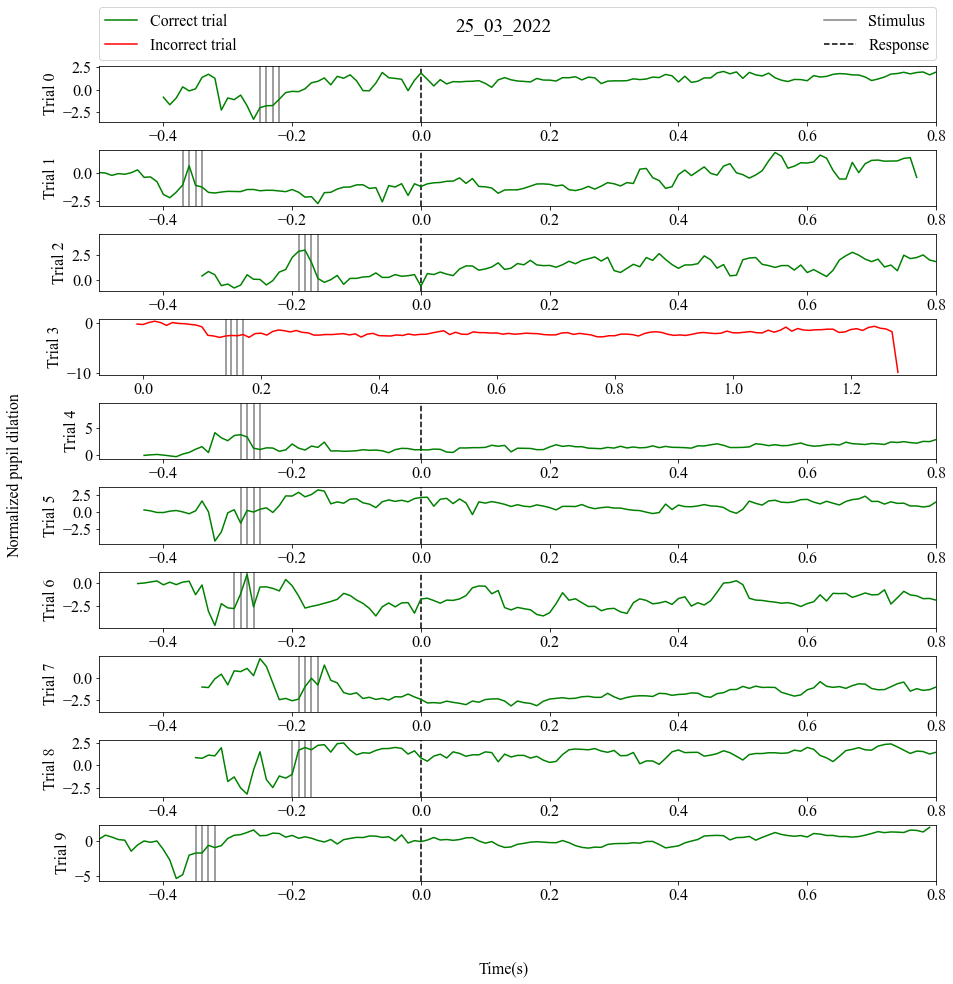

<Figure size 432x288 with 0 Axes>

In [5]:
# What mice have proper DLC
correct_dlc = {'SNA-100101':['25_03_2022'], 'SNA-100103':['24_03_2022'], 'SNA-100104':['24_03_2022'], 'SNA-102383':['10_05_2022', '11_05_2022', '12_05_2022'],
           'SNA-102384':['10_05_2022', '11_05_2022', '12_05_2022'], 'SNA-102385':['12_05_2022'], 'SNA-102386':['10_05_2022', '11_05_2022']} 
fps = 200
marker = ('left_whisker','whisker_tip', 'x')
marker = ('pupil', 'dilation')
trace_folder = 'C:/Users/miksc/Desktop/pupil_traces_pre/'

for ID in correct_dlc:
    path_to_data = root+ID
    mouse = Mouse_Data(path_to_data)
    dlc_dict = get_dlc_dict(mouse)
    norm_pupil_all = []
    for session in correct_dlc[ID]:
        pupil_sizes = get_pupil_size(dlc_dict[session])
        norm_pupil_size = normalize_pupil_size(pupil_sizes, n_avg=5)
        norm_pupil_all.append(norm_pupil_size)
        plot_session_traces(mouse, session, marker, plots_per_fig=10)#, peak=False, save=True, destfolder=trace_folder) 
        break
    break

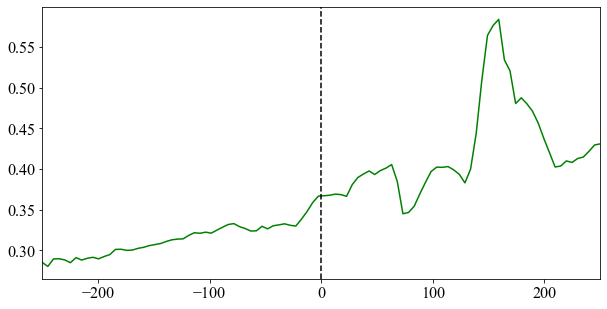

In [6]:
mouse = Mouse_Data(root+'SNA-100104')
correct_session = '24_03_2022'
session_data = mouse.all_data[correct_session]
dlc_dict = get_dlc_dict(mouse)
normalized_trace = normalize_whisking(dlc_dict[correct_session]['left_whisker']['whisker_tip'])

window = 250
succes, fail = average_whisker_movement(session_data, normalized_trace, window=window)
succes_avg, succes_std = succes
trace_len = len(succes_avg)
# Now plot
plt.figure(figsize=(10,5))
x = np.linspace(-window, window, trace_len)
plt.plot(x, succes_avg, color='green')
plt.axvline(0, linestyle='--', color='black')
plt.xlim([-window, window])

plt.show()

In [9]:
correct_dlc = {'SNA-100101':['25_03_2022'], 'SNA-100103':['24_03_2022'], 'SNA-100104':['24_03_2022'], 'SNA-102383':['10_05_2022', '11_05_2022', '12_05_2022'],
           'SNA-102384':['10_05_2022', '11_05_2022', '12_05_2022'], 'SNA-102385':['12_05_2022'], 'SNA-102386':['10_05_2022', '11_05_2022']} 
fps = 200
marker = ('left_whisker','whisker_tip', 'x')
trace_folder = 'C:/Users/miksc/Desktop/whisker_traces/'

for ID in correct_dlc:
    path_to_data = root+ID
    mouse = Mouse_Data(path_to_data)
    dlc_dict = get_dlc_dict(mouse)
    for session in correct_dlc[ID]:
        pupil_size = get_pupil_size(dlc_dict[session])
        plot_session_traces(mouse, session, marker, plots_per_fig=10)#, save=True, destfolder=trace_folder) 
        break
    break

('left_whisker', 'whisker_tip', 'x')


UnboundLocalError: local variable 'nframes' referenced before assignment

In [ ]:
# Create a dlc_dict if there are any DLC files
for mouse in ctrl_list:
    try:
        dlc_dict = get_dlc_dict(mouse)
        istheredlc = True
    except:
        istheredlc = False
        print(f'{mouse.id} contains no DLC data')

    # Now lets get the index of the succesful trials
    if istheredlc:
        print(istheredlc, mouse.id)
        for session in mouse.sessions:
            session_data = mouse.all_data[session]

            # Get DLC data
            file_sesh = session.replace('_','-')
            path_i_need = root+mouse.id+file_sesh+'/prepped/'

            for succes_idx in session_data.loc[session_data['succes']==True].index:
                trace = dlc_dict[session]


# Every session cam-position is different so get the average over one session's succesful and unsuccesful trials
avg_whisking = []
for mouse in ctrl_list:
    for session in mouse.sessions:
        session_data = mouse.all_data[session]
        
        # Get the succesful trials
        for succes_idx in session_data.loc[session_data['succes']==True].index:
            # Get DLC data but not all animals have data
            try:
                dlc_file_dict = get_dlc_dict(mouse)
                
                istheredlc = True
            except:
                istheirdlc = False
                print(f'{mouse.id} contains no DLC data')
                break
        if not istheirdlc:
            break
        
x_pos = dlc_file_dict['24_03_2022']['left_whisker']['whisker_tip']['x']
y_pos = dlc_file_dict['24_03_2022']['left_whisker']['whisker_tip']['y']


# Get the average response time to plot in graph
succes_trials = mouse.all_data['24_03_2022'].loc[mouse.all_data['24_03_2022']['succes']==True]
# succes_trials = succes_trials.loc[succes_trials['stim_t']>=827.32]
succes_avg_rt = np.mean(succes_trials['response_t']) 
fail_trials = mouse.all_data['24_03_2022'].loc[mouse.all_data['24_03_2022']['succes']==False]

# Select succesful trial chunks and average
x_chunked = chunks(x_pos, 255)
succes_x = []
print(len(x_chunked))
print(np.max(succes_trials.index))
for i in succes_trials.index:
    succes_x.append(x_chunked[i])
succes_avg_x, succes_std = get_average_cum_score(succes_x)

# Now plot
plt.figure(figsize=(10,5))
plt.plot(succes_avg_x, color='green')
plt.axvline(15, color='gray', linestyle='--')
plt.axvline(succes_avg_rt*200, color='black', linestyle='--')
plt.show()

# Select fail trial chunks and average
x_chunked = chunks(x_pos, 255)
fail_x = []
for i in fail_trials.index:
    fail_x.append(x_chunked[i])
fail_avg_x, fail_std = get_average_cum_score(fail_x)

# Now plot
plt.figure(figsize=(10,5))
plt.plot(fail_avg_x, color='red')
plt.axvline(15, color='gray', linestyle='--')
plt.show()


In [ ]:
sesh_pupil = norm_pupil_all[0]
sesh_pupil = [list(pupil_array) for pupil_array in sesh_pupil]
# print(type(sesh_pupil))
# print(sesh_pupil)
plt.pcolormesh(sesh_pupil)
plt.show()

In [ ]:
import cv2
# ID = 'SNA-102384'
# sesh='10_05_2022'
ID = 'SNA-100101'
session = '25_03_2022'
test_dict = get_dlc_dict(mouse)
print(mouse.id, '/', session)

# cap = cv2.VideoCapture(r"C:/Users/miksc/Documents/mStim_data/SNA-102384/10-05-2022/prepped/Basler_acA1300-200um__22523118__20220510_135023747_left.mp4")
cap = cv2.VideoCapture(r"C:\Users\miksc\Documents\mStim_data\SNA-100101\25-03-2022\prepped\Basler_acA1300-200um__23512331__20220325_161114187_pupil.mp4")

frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
duration_s = cap.get(cv2.CAP_PROP_POS_MSEC)/1000
trial_count = round(frame_count/130)

session_data = mouse.all_data[session]
n_trials = len(session_data)

print(f'From Spike2: {n_trials} trials')
print(f'From frames: {trial_count} trials')


In [ ]:
display(test_dict)

In [ ]:
def average_session_behaviour(session_data, full_whisker_trace, behaviour='whisking', center_method='stimulus', n_frames=255, fps=200):
    ''' docstring
        INPUT:
            session_data(pd.DataFrame) = the Mouse_Data.all_data for a session 
            full_whisker_traces(pd.Series): (normalized) whisker position of all frames in session
            behaviour(str): behaviour you want to average
            center_method(str): average centered around response(default) or stimulation
            n_frames(int): number of frames per trial whisker
            fps(int):
        OUTPUT:
            succes_stats(tuple): succes_avg, succes_std
            failed_stats(tuple): failed_avg, failed_std
    '''
    # Set some basics & check user input
    T = 1/fps
    centers = ['stimulus', 'response']
    if center_method not in centers:
        raise NameError(f'Invalid center_method, try: {centers}')
    
    # Chunk the traces in trials and add to session_data
    trial_traces = pd.Series(chunks(full_whisker_trace, n_frames))
    session_data =  session_data.assign(trace = trial_traces)
    
    # Select all succesful trials and traces, where a response was registered
    succes_trials = session_data.loc[session_data['succes']==True]
    succes_traces = [trial_traces[trial_idx] for trial_idx in succes_trials.index]
    failed_trials = session_data.loc[session_data['succes']==False]
    failed_traces = [trial_traces[trial_idx] for trial_idx in failed_trials.index]
    
    # Get the minimum and maximum number of frames pre response
    x_centers = [get_x_centered(response_t, fps, n_frames)*T for response_t in succes_trials['response_t']]
    x_center = x_centers[0]
    stim_idx = [np.argwhere(x_center==0)[0][0] for x_center in x_centers]
    succes_trials = succes_trials.assign(response_idx = stim_idx) #!!SHOULD THIS BE STIM INDEX?
    
    # Get min max
    min_idx = np.min(succes_trials['response_idx']) # Least frames captured before the lick responce
    max_idx = np.max(succes_trials['response_idx']) # Most frames captured before the lick response (late lick, high response time)
    
    # Average the trace around the response or the stimulation
    if center_method == 'response':
        # Fill every trace-array until min and max frames with their first or last value
        for trial_idx, trial_data in succes_trials.iterrows():
            # Get the difference in frames before and after response 
            response_idx = trial_data['response_idx']
            fill_before = abs(response_idx - min_idx) # How many frames to add to this frame list with first value
            fill_after = abs(response_idx - max_idx)

            # Get the values to fill with
            begin_position = trial_data['trace'][0]
            end_position = trial_data['trace'][-1]

            # Append to trace list
            [succes_trials.loc[trial_idx, 'trace'].insert(0, begin_position) for _ in range(fill_before)]
            succes_trials.loc[trial_idx, 'trace'].extend([end_position]*fill_after)
            
    # Else if center not response then it has to be stimulus so we can just average
    # Get the average trace over all extended/succesful traces and failed traces
    succes_avg, succes_std = get_average_cum_score(succes_traces)
    failed_avg, failed_std = get_average_cum_score(failed_traces)
            
    return (succes_avg, succes_std), (failed_avg, failed_std)